# PDE-constrained optimization with neural network chemical potential

In this notebook, we show how to use the PDEModel class to perform PDE-constrained optimization with a Legendre polynomial basis representing the chemical potential and diffusivity terms.

We will use 3D data and simulations during the optimization.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pde_opt
from pde_opt.pde_model import PDEModel
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard3DPeriodic
from pde_opt.numerics.solvers import SemiImplicitFourierSpectral
from pde_opt.numerics.domains import Domain
from pde_opt.numerics.functions.legendre import ChemicalPotentialLegendrePolynomials, DiffusionLegendrePolynomials

import equinox as eqx
import diffrax

We will first create the domain for the PDE. We choose to use a small domain so the code runs in a reasonable amount of time in the notebook.

In [2]:
Nx = Ny = Nz = 32
Lx = Ly = Lz = 0.01 * Nx

domain = Domain(
    (Nx, Ny, Nz),
    (
        (-Lx / 2, Lx / 2),
        (-Ly / 2, Ly / 2),
        (-Lz / 2, Lz / 2),
    ),
    "dimensionless",
)

Constructing the PDE model for optimization just involves specifying the equation, domain, and time stepping method.

In [3]:
opt_model = PDEModel(
    equation_type=CahnHilliard3DPeriodic,
    domain=domain,
    solver_type=SemiImplicitFourierSpectral,
)

Here, we set parameter values for the terms in the Cahn-Hilliard equation. These parameters will serve as our "ground truth", which we will try to recover in our optimization. In this example, we only focus on learning the chemical potential.

In [14]:
params = {"kappa": 0.002, "mu": lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c), "D": lambda c: 0.15 * jnp.ones_like(c)}

solver_params = {"A": 0.5}

Now we can solve the system with the parameters to get the training dataset we will use in the optimization.

In [15]:
key = jax.random.PRNGKey(0)
y0 = jnp.clip(0.01 * jax.random.normal(key, (Nx, Ny, Nz)) + 0.5, 0.0, 1.0)
ts = jnp.linspace(0.0, 0.2, 100)
sol = opt_model.solve(params, y0, ts, solver_params, dt0=0.000001, max_steps=1000000)

We can visualize what this solution looks like.

In [16]:
def visualize_3D_solution(sol, ts, t_slices, z_slices):
    fig, ax = plt.subplots(len(z_slices), len(t_slices))
    for j, t in enumerate(t_slices):
        ax[0,j].set_title(f"t = {ts[t]:.3f}")
    for i, z in enumerate(z_slices):
        ax[i,0].set_ylabel(f"z = {z}")
        for j, t in enumerate(t_slices):
            ax[i,j].imshow(sol[t][:,:,z], vmin=0.0, vmax=1.0)
    plt.tight_layout()
    plt.show()
    

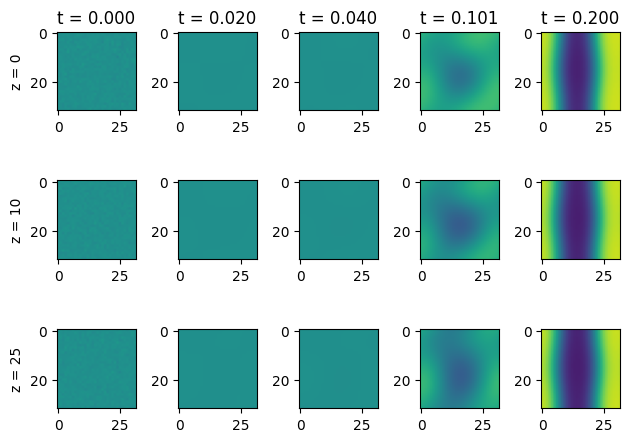

In [17]:
z_slices = [0, 10, 25]
t_slices = [0, 10, 20, 50, -1]
visualize_3D_solution(sol, ts, t_slices, z_slices)

We will use a Legendre polynomial expansion to represent the Chemical Potential and Diffusivity functions. To speed up the convergence, we include the entropic prior on the chemical potential and we only use one term in the expansion for the diffusivity (for constant diffusivity). 

In [19]:
chem_pot_model = ChemicalPotentialLegendrePolynomials(jnp.zeros(6), lambda x: jnp.log(x / (1.0 - x)))
diffusivity_model = DiffusionLegendrePolynomials(jnp.log(0.05) * jnp.ones(1))

The train function expects the data is passed in as a dictionary with the time points specified in the 'ts' key and the fields specified in the 'ys' key.

We must also pass in a list of lists indicating which indices we want to include in the simulation. Each inner list has the following format: [starting time, time to evaluate loss, time to evaluate loss, ...., final time to evaluate loss]. When computing the total loss, we vmap over each list and average.

In [20]:
data = {}
data['ys'] = sol
data['ts'] = ts

inds = [[30,40,50], [50,60,70], [70,80,90]]

Now we need an initial set of parameters at which to start the optimization at. For the chemical potential and diffusivity, our initial parameters are the Legendre polynomial models that we defined above. This is a nice part of using Equinox to create our models, as the whole model is represented as a PyTree, and we can use filtered operations like JIT and grad to properly extract the arrays, or use partition and combine operations to separate the array and non-array leaves. We can therefore pass full equinox models as "parameters" in our equation, which makes the interface much more general and easier to use.

We put the parameters or models we wish to optimize over in a separate dictionary than the parameters that we wish to remain fixed/static. Finally, we can regularize the parameters using a weights dictionary. This dictionary must match the structure of the optimization parameters dictionary, and the PyTrees for each key must have the same structure. Then we can use tree_map and tree_reduce to compute the regularization term. The lambda_reg is then a global scale factor applied to every regularization term. Here, we add a regularization to penalize high frequency components of the models. The specific regularization weights come from regularizing derivatives of the Legendre polynomials.

In [21]:
init_params = {
    "mu": chem_pot_model,
    "D": diffusivity_model,
}

static_params = {
    "kappa": 0.002,
}

solver_parameters = {
    "A": 0.5,
}

weights = {
    "mu": ChemicalPotentialLegendrePolynomials(jnp.array([0, 2, 6, 12, 20, 30])),
    "D": DiffusionLegendrePolynomials(jnp.array([0]))
}

lambda_reg = 0.0

Let's now visualize what the initial solution looks like for our starting guess of chemical potential. Note that there is no phase separation!

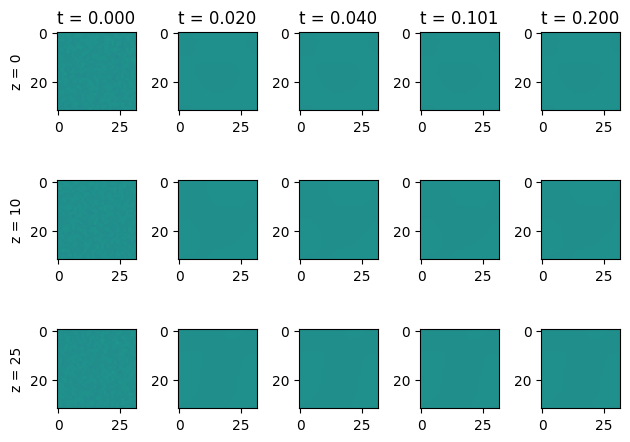

In [22]:
test_sol = opt_model.solve({**init_params, **static_params}, y0, ts, solver_parameters, dt0=0.000001, max_steps=1000000)

z_slices = [0, 10, 25]
t_slices = [0, 10, 20, 50, -1]
visualize_3D_solution(test_sol, ts, t_slices, z_slices)

We can now pass in the dataset, the optimization indices, the parameters we want to fit, the static parameters, and the regularization weights into the train function. This should take around 4 minutes per 100 steps and the results will be improved for more steps.

In [23]:
res = opt_model.train(data, inds, init_params, static_params, solver_parameters, weights, lambda_reg, method="least_squares", max_steps=100)

Step: 0, Accepted steps: 0, Steps since acceptance: 0, Loss on this step: 4875.34912109375, Loss on the last accepted step: 0.0, Step size: 1.0
Step: 1, Accepted steps: 1, Steps since acceptance: 0, Loss on this step: nan, Loss on the last accepted step: 4875.34912109375, Step size: 0.25
Step: 2, Accepted steps: 1, Steps since acceptance: 1, Loss on this step: nan, Loss on the last accepted step: 4875.34912109375, Step size: 0.0625
Step: 3, Accepted steps: 1, Steps since acceptance: 2, Loss on this step: 2024.0628662109375, Loss on the last accepted step: 4875.34912109375, Step size: 0.0625
Step: 4, Accepted steps: 2, Steps since acceptance: 0, Loss on this step: 1730.604248046875, Loss on the last accepted step: 2024.0628662109375, Step size: 0.21875
Step: 5, Accepted steps: 3, Steps since acceptance: 0, Loss on this step: 1386.0859375, Loss on the last accepted step: 1730.604248046875, Step size: 0.765625
Step: 6, Accepted steps: 4, Steps since acceptance: 0, Loss on this step: 2575.

Finally, we can see that our learned chemical potential and diffusivity matches the ground truth values.

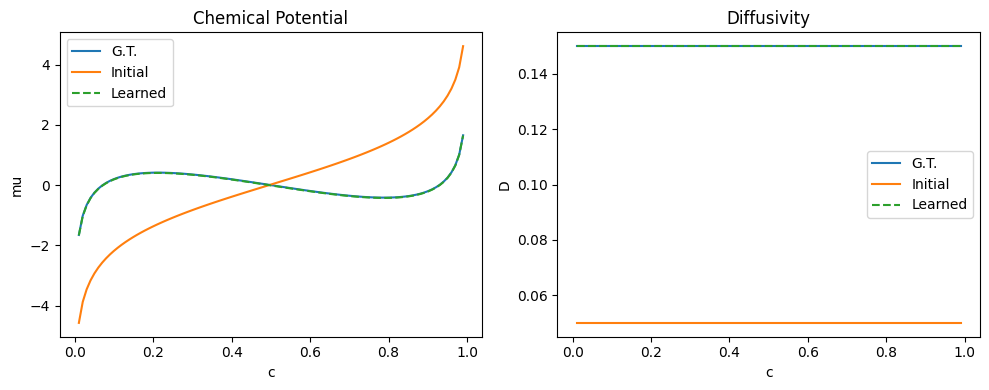

In [27]:
cs = jnp.linspace(0.01, 0.99, 100)

mu_gt = params['mu'](cs)
d_gt = params['D'](cs)

mu_init = init_params['mu'](cs)
mu_opt = res['mu'](cs)

d_init = init_params['D'](cs)
d_opt = res['D'](cs)

idx_05 = jnp.argmin(jnp.abs(cs - 0.5))  # Find index closest to c=0.5
shift = mu_opt[idx_05]
shift_init = mu_init[idx_05]
mu_opt = mu_opt - shift
mu_init = mu_init - shift_init


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title('Chemical Potential')
ax[1].set_title('Diffusivity')
ax[0].plot(cs, mu_gt, label='G.T.')
ax[0].plot(cs, mu_init, label='Initial')
ax[0].plot(cs, mu_opt, label='Learned', linestyle='--')
ax[1].plot(cs, d_gt, label='G.T.')
ax[1].plot(cs, d_init, label='Initial')
ax[1].plot(cs, d_opt, label='Learned', linestyle='--')
ax[0].set_xlabel('c')
ax[1].set_xlabel('c')
ax[0].set_ylabel('mu')
ax[1].set_ylabel('D')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

And we can use this chemical potential and diffusivity to simulate the full PDE and compare with the ground truth simulation.

Ground truth solution:


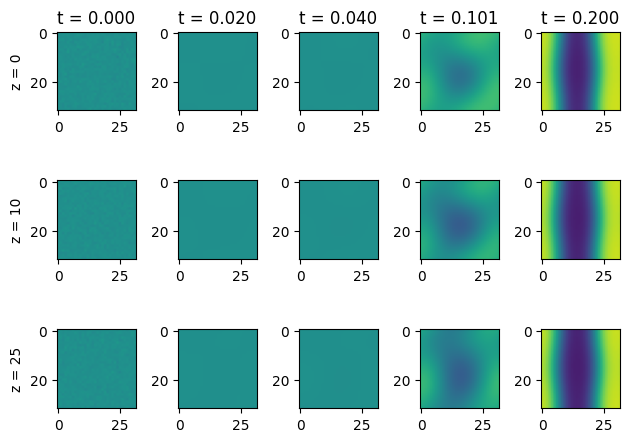

Optimized solution:


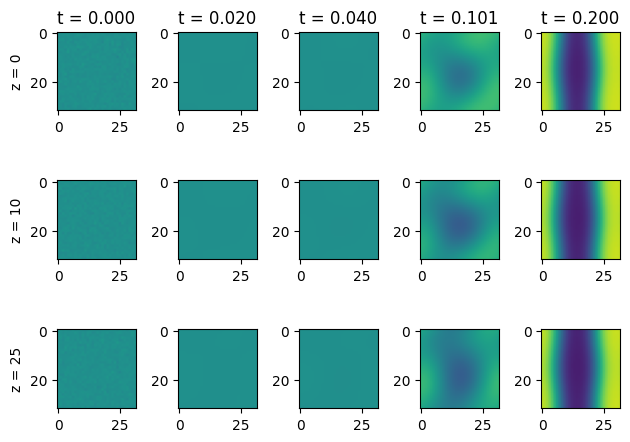

In [28]:
opt_sol = opt_model.solve(res, y0, ts, solver_parameters, dt0=0.000001, max_steps=1000000)

print("Ground truth solution:")
z_slices = [0, 10, 25]
t_slices = [0, 10, 20, 50, -1]
visualize_3D_solution(sol, ts, t_slices, z_slices)

print("Optimized solution:")
visualize_3D_solution(opt_sol, ts, t_slices, z_slices)
